In [1]:
!pip install -q mlflow nlp datasets openai

In [2]:
#imports
import pandas as pd
import gc
import re
import numpy as np
import torch
import transformers
from transformers import AutoModel, AutoTokenizer, TextDataset, LineByLineTextDataset, DataCollatorForLanguageModeling, \
pipeline, Trainer, TrainingArguments, DataCollatorWithPadding, AutoModelForSequenceClassification
from huggingface_hub import login
from torch import cuda, bfloat16
from datasets import load_dataset
from nlp import Dataset
from imblearn.over_sampling import RandomOverSampler
import datasets
from transformers import pipeline
from bs4 import BeautifulSoup
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from pathlib import Path
import csv
from openai import OpenAI
tqdm.pandas()

In [3]:
# set parameters
train_fraction = 0.7 # fraction of a dataset used for training (the rest used for validation)
num_train_epochs = 3 # epochs to train
batch_size = 16 # batch size for training and validation
warmup_steps = 50
weight_decay = 0.02
bert_model = "google-bert/bert-base-uncased"
output_dir = "./phishing-email-detection"

In [4]:
dataset = load_dataset("zefang-liu/phishing-email-dataset", trust_remote_code=True)
df = dataset['train'].to_pandas()
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
print(df.shape)
df.sample(5).T

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(17539, 2)


,10664,14069,1188,6544,1206
Email Text,"Hi guys,\n\tI'm looking for help on this one. ...",Short version:\nT-Mobile Broadband is in the p...,"hiya , , find your meds here . . stanchion biz...","cialis , xanax , valium , viagra at low price ...","cialis , xanax , valium , viagra at low price ..."
Email Type,Safe Email,Safe Email,Phishing Email,Phishing Email,Phishing Email


In [5]:
# create target
df['label'] = (df['Email Type']=="Phishing Email").astype(int)
df['title'] = df['Email Text']
df = df[['title', 'label']]

print(df.shape)
df.sample(20)

(17539, 2)


,title,label
33,release of agfl home page this message announc...,0
17206,analyst & associate program - business school ...,0
1953,"fw : mark boland - cv vince : tony vasut , ano...",0
276,Tired of Mounting Credit Card Debt?\nFrustrate...,1
9932,march nominations at shell deer park - - - - -...,0
5363,tw ' s christmas luncheon steve harris and the...,0
13273,re : hpl meter # 986563 texaco fee c / p clem ...,0
8253,board presentation attached is the board prese...,0
3723,hello thtijred of only las $ tinfg a few minut...,1
12640,case-marked locatives does anyone know about l...,0


In [6]:
# drop null records
df.dropna(inplace=True)
df['label'].mean()

<ipython-input-6-17ea06fec25c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


0.37393089291823467

In [7]:
# random oversampling of minority class
y = df[['label']]
df = df.drop(['label'], axis=1)
ros = RandomOverSampler(random_state=83)
df, y_resampled = ros.fit_resample(df, y)
del y
df['label'] = y_resampled
print(df.shape)
del y_resampled
gc.collect()

(21960, 2)


0

In [8]:
medium_dataset = Dataset.from_pandas(df)
del df
gc.collect()

0

In [9]:
tokenizer = AutoTokenizer.from_pretrained(bert_model, use_fast=True, low_cpu_mem_usage=False)

# simple function to batch tokenize utterances with truncation
def preprocess_function(examples):
    return tokenizer(examples["title"], truncation=True)

medium_dataset = medium_dataset.map(preprocess_function, batched=True)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


  0%|          | 0/22 [00:00<?, ?it/s]

In [10]:
# Dataset has a built in train test split method
medium_dataset = medium_dataset.train_test_split(test_size=1-train_fraction)
medium_dataset
medium_dataset.remove_column_("title") # remove the text column because we don't need to keep it in memory anymore

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

In [11]:
# DataCollatorWithPadding creates batch of data. It also dynamically pads text to the
#  length of the longest element in the batch, making them all the same length.
#  It's possible to pad text in the tokenizer function with padding=True but dynamic padding is more efficient.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [12]:
tokenizer.decode(medium_dataset['train'][0]['input_ids'])

'[CLS] own your very own free casino and sportsbook! earning potential : $ 75 - $ 150, 000 + yearly p / t!! toll free : 1 - 866 - 522 - 8575 24hrs. international calls : 1 - 954 - 610 - 9386 ted koppel, nightline... " not only is internet gambling already possible, already a modestly thriving industry, it promises to become huge " we create your very own online casino and sportsbook absolutely free!! you receive the highest payouts! 25 - 50 %, with lifetime residuals! our marketing tools assist you in easily generating revenue. 100 people losing just $ 500 a month in your casino gives you $ 25, 000 a month!!! * if you are one of the first 25 people to call today, receive a free marketing package! * available in a limited number of area codes throughout the usa. * available on a first come first serve basis in your area. toll free 1 - 866 - 522 - 8575 24hrs. international calls : 954 - 610 - 9386 or email your name and phone number to : mailto : respond _ to _ dave @ excite. com? subjec

# Loading and training model

In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    bert_model, num_labels=2,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

model.config.id2label = {0: 'SAFE EMAIL', 1: 'PHISHING EMAIL'}

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

109.483778


In [15]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Compute accuracy
    accuracy = accuracy_score(labels, predictions)

    # Compute precision, recall, and F1 score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

In [16]:
training_args = TrainingArguments(
    output_dir=output_dir,
    logging_dir='./logs',
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_strategy='steps',
    logging_first_step=True,
    load_best_model_at_end=True,
    logging_steps=1,
    eval_strategy='epoch',
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    eval_steps=1,
    save_strategy='epoch',
    report_to="mlflow",  # log to mlflow
)

# Define the trainer, initiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=medium_dataset['train'],
    eval_dataset=medium_dataset['test'],
    data_collator=data_collator
)

In [17]:
# Get initial metrics
trainer.evaluate()

{'eval_loss': 0.7386114597320557,
 'eval_model_preparation_time': 0.0036,
 'eval_accuracy': 0.4943086963120352,
 'eval_precision': 0.5603593384737388,
 'eval_recall': 0.4943086963120352,
 'eval_f1': 0.3281721977905359,
 'eval_runtime': 45.2325,
 'eval_samples_per_second': 145.669,
 'eval_steps_per_second': 9.108}

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy,Precision,Recall,F1
1,0.001100,0.051638,0.003600,0.986493,0.986631,0.986493,0.986493
2,0.000100,0.049452,0.003600,0.991349,0.991356,0.991349,0.991349
3,0.000000,0.045463,0.003600,0.993474,0.993474,0.993474,0.993474


TrainOutput(global_step=2883, training_loss=0.04335314220014997, metrics={'train_runtime': 1066.1725, 'train_samples_per_second': 43.251, 'train_steps_per_second': 2.704, 'total_flos': 1.21102207672752e+16, 'train_loss': 0.04335314220014997, 'epoch': 3.0})

In [19]:
trainer.evaluate()

{'eval_loss': 0.04546274617314339,
 'eval_model_preparation_time': 0.0036,
 'eval_accuracy': 0.9934739717711337,
 'eval_precision': 0.9934740409966147,
 'eval_recall': 0.9934739717711337,
 'eval_f1': 0.9934739834975524,
 'eval_runtime': 44.3649,
 'eval_samples_per_second': 148.518,
 'eval_steps_per_second': 9.287,
 'epoch': 3.0}

# Visualisations

Number of evaluation loss points: 4


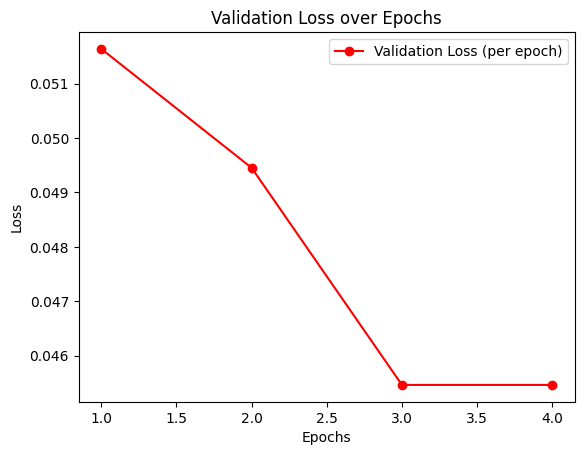

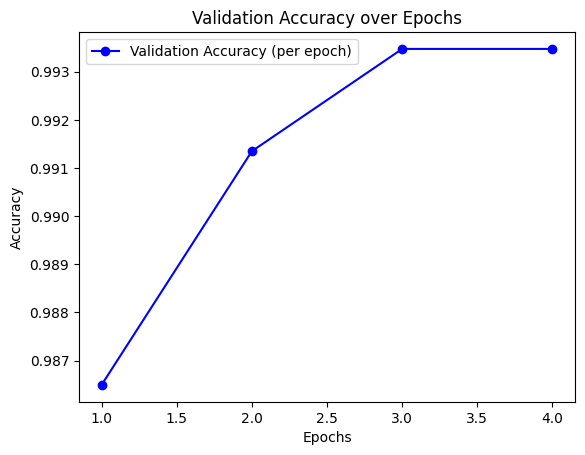

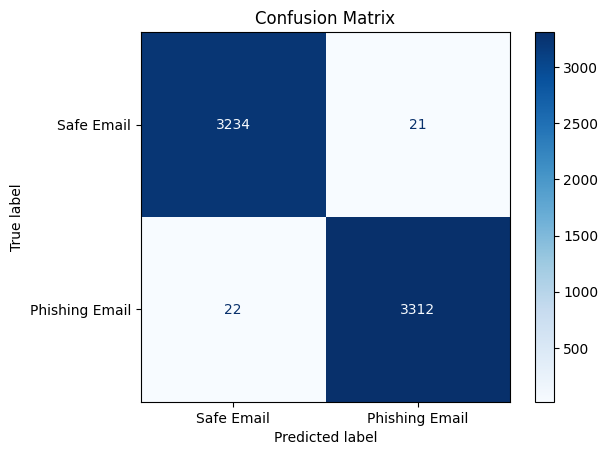

In [20]:
log_history = trainer.state.log_history

eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]

print(f"Number of evaluation loss points: {len(eval_loss)}")

# Check how many evaluations happened
epochs_eval = range(1, len(eval_loss) + 1)

plt.plot(epochs_eval, eval_loss, 'ro-', label='Validation Loss (per epoch)')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs_eval, eval_accuracy, 'bo-', label='Validation Accuracy (per epoch)')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

predictions = trainer.predict(medium_dataset['test'])
predicted_labels = np.argmax(predictions.predictions, axis=-1)
true_labels = medium_dataset['test']['label']

class_names = ['Safe Email', 'Phishing Email']

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Saving the model and checking its performance with a sample

In [21]:
trainer.save_model()
tokenizer.save_vocabulary(save_directory=output_dir)

('./phishing-email-detection/vocab.txt',)

In [22]:
# make a classification pipeline
pipe = pipeline("text-classification", output_dir, tokenizer=bert_model)
sample_title = '''Why do employees leave companies — analysis of IBM employee data'''
pipe(sample_title, top_k=None)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'SAFE EMAIL', 'score': 0.9997156262397766},
 {'label': 'PHISHING EMAIL', 'score': 0.00028437585569918156}]

In [23]:
# use the upper-case version
sample_title2 = sample_title.upper()
pipe(sample_title2, top_k=None)

[{'label': 'SAFE EMAIL', 'score': 0.9997156262397766},
 {'label': 'PHISHING EMAIL', 'score': 0.00028437585569918156}]

In [24]:
# more refined version
sample_title3 = '''Why do employees leave companies?'''
pipe(sample_title3, top_k=None)

[{'label': 'SAFE EMAIL', 'score': 0.9953664541244507},
 {'label': 'PHISHING EMAIL', 'score': 0.004633587319403887}]

In [25]:
# Initialize the OpenAI client
client = OpenAI(api_key="API_KEY")

# Function to validate email address format
def is_valid_email(email):
    return '@' in email and '.' in email

# Function to classify and extract email
def classify_and_extract_email(text, pipe, threshold=0.5):
    results = pipe(text, top_k=None)
    print("Classification results: ", results)
    for result in results:
        if result['label'] == 'PHISHING EMAIL' and result['score'] >= threshold:
            return result
    return results

# Function to generate a counter-response to phishing email using ChatGPT
def generate_counter_response(phishing_email_content):
    prompt = (
        "You are an expert in cybersecurity and email security."
        "Here is a phishing email:\n\n"
        f"{phishing_email_content}\n\n"
        "Craft a response to this phishing email that engages the sender."
        "Your goal is to gather more information about the sender or their intentions."
        "Ensure the response appears interested in the offer, but subtly aims to expose or trap the sender."
        "Avoid directly revealing that you are aware of the phishing attempt."
        "Make the response convincing and professional, encouraging further interaction that could reveal more about the sender’s motives."
    )

    response = client.chat.completions.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": prompt}
        ],
    )
    return print(response.choices[0].message.content)

# Function to save the phishing email to a CSV file
def save_to_csv(email, subject, content):
    output_file = Path("phishing_emails.csv")

    # Check if the file exists to write header only for the first time
    file_exists = output_file.exists()

    with open(output_file, mode="a", newline="") as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(["Email Address", "Subject", "Email Content"])  # Write header if the file is created first time
        writer.writerow([email, subject, content])

# Main program function to get email details and classify it
def main():
  while True:
    # Input email details from the user
    email_address = input("Enter the email address:")
    if not is_valid_email(email_address):
      print("Invalid email address! Please enter a valid email.")
      continue

    subject = input("Enter the subject:")
    email_content = input("Enter the email content:")

    if not email_address or not subject or not email_content:
        print("All fields must be filled!")
        continue

    # Classify the email content
    result = classify_and_extract_email(email_content, classification_pipe)

    if result['label'] == 'PHISHING EMAIL':
        # Generate a counter response using ChatGPT
        print(f"Phishing email detected! \nGenerated response:\n")
        response = generate_counter_response(email_content)

        # Save to CSV
        save_to_csv(email_address, subject, email_content)
        print("Phishing email information saved to CSV.")

    else:
      print("The email is classified as safe.")

    # Option to process another email or exit
    another = input("Do you want to process another email? (yes/no): ").lower()
    if another != 'yes':
      break

# Directory where the model and tokenizer are saved
output_dir = "phishing-email-detection"

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model = AutoModelForSequenceClassification.from_pretrained(output_dir)

# Load the text-classification pipeline
classification_pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

# Run the main program
if __name__ == "__main__":
    main()

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Enter the email address:test@example.com
Enter the subject:Claim your free gift card!
Enter the email content:Click NOW on the link below to claim your FREE gift card!
Classification results:  [{'label': 'PHISHING EMAIL', 'score': 0.9999234676361084}, {'label': 'SAFE EMAIL', 'score': 7.653208012925461e-05}]
Phishing email detected! 
Generated response:

Subject: Re: Inquiry Regarding Amazing Gift Card Offer! 

Hello, 

I am thrilled to receive your email with such exciting news! Who wouldn't love a free gift card? Before I proceed, I would like to learn more about this astounding deal for personal clarification. 

1. Could you provide me more details about the company you are representing? A brief description or a website link would be wonderful. 
2. Also, I'm interested to understand more about the origin and funding of these free gift cards. This will help me share this great news with more friends and family. 
3. Lastly, could you enlighten me on the process and timeline to claim th